Chargement des donn√©es et pr√©paration pour le mod√®le Machine Learning

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

# 1. Chargement des donn√©es pr√©process√©es
print("Chargement des donn√©es...")
X = np.load('/content/drive/MyDrive/data/preprocessed/X_train.npy')
y = np.load('/content/drive/MyDrive/data/preprocessed/y_train.npy')

Chargement des donn√©es...


In [ ]:
# V√©rification des dimensions
print(f"Shape de X: {X.shape} | Shape de y: {y.shape}")


Shape de X: (5619, 224, 224, 1) | Shape de y: (5619,)


R√©duction de dimension avec PCA pour acc√©l√©rer l'entra√Ænement

In [ ]:
# 2. R√©duction de dimension si n√©cessaire (pour acc√©l√©rer l'entra√Ænement)
def apply_pca(X, n_components=0.95):
    """Applique PCA pour conserver 95% de la variance"""
    original_shape = X.shape
    X_flat = X.reshape(X.shape[0], -1)  # Aplatir les images

    pca = PCA(n_components=n_components, random_state=42)
    X_reduced = pca.fit_transform(X_flat)

    print(f"R√©duction PCA : {X_flat.shape[1]} features ‚Üí {X_reduced.shape[1]} features")
    print(f"Variance expliqu√©e : {np.sum(pca.explained_variance_ratio_):.2%}")

    return X_reduced, pca

# Application de PCA seulement si les images sont trop grandes
if X.shape[1] * X.shape[2] > 1000:  # Seuil arbitraire
    X_processed, pca = apply_pca(X)
else:
    X_processed = X.reshape(X.shape[0], -1)  # Simple aplatissement

R√©duction PCA : 50176 features ‚Üí 2134 features
Variance expliqu√©e : 95.00%


Division des donn√©es en ensembles d'entra√Ænement et de test

In [ ]:
# 3. Division des donn√©es
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

Configuration optimis√©e du mod√®le Random Forest

In [ ]:
# 4. Configuration du Random Forest optimis√©
rf_params = {
    'n_estimators': 150,         # Un peu moins d'arbres (200 ‚Üí 150)
    'max_depth': 10,             # Profondeur plus faible (√©vite les arbres trop complexes)
    'min_samples_split': 10,     # Forcer √† avoir plus d'√©chantillons pour chaque split
    'min_samples_leaf': 4,       # Minimum de samples par feuille
    'max_features': 'sqrt',      # Garde cette valeur
    'n_jobs': -1,
    'random_state': 42,
    'class_weight': 'balanced'   # Gestion automatique du d√©s√©quilibre
}
print("\nConfiguration du Random Forest:")
for k, v in rf_params.items():
    print(f"{k}: {v}")



Configuration du Random Forest:
n_estimators: 150
max_depth: 10
min_samples_split: 10
min_samples_leaf: 4
max_features: sqrt
n_jobs: -1
random_state: 42
class_weight: balanced


Entra√Ænement du mod√®le Random Forest

In [ ]:
# 5. Entra√Ænement du mod√®le
print("\nEntra√Ænement en cours...")
start_time = time.time()

rf_model = RandomForestClassifier(**rf_params)
rf_model.fit(X_train, y_train)

train_time = time.time() - start_time
print(f"Entra√Ænement termin√© en {train_time:.2f} secondes")


Entra√Ænement en cours...
Entra√Ænement termin√© en 25.76 secondes


√âvaluation du mod√®le Random Forest

√âvaluation sur le jeu de test:

Rapport de classification:
              precision    recall  f1-score   support

    No Tumor       0.84      0.65      0.73       320
       Tumor       0.87      0.95      0.91       804

    accuracy                           0.86      1124
   macro avg       0.85      0.80      0.82      1124
weighted avg       0.86      0.86      0.86      1124


Matrice de confusion:


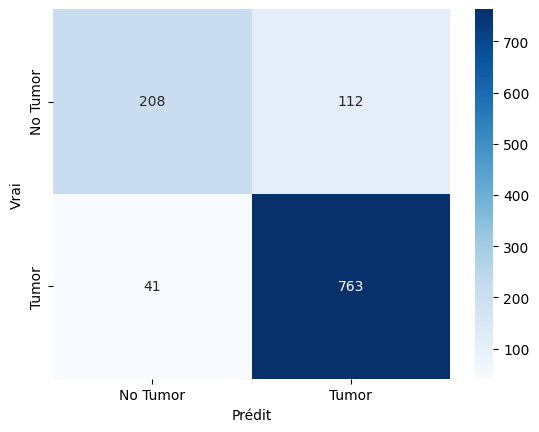


AUC-ROC: 0.9116



In [ ]:
# 6. √âvaluation
def evaluate_model(model, X_test, y_test):
    """√âvalue le mod√®le et affiche les m√©triques"""
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print("\n" + "="*50)
    print("Rapport de classification:")
    print(classification_report(y_test, y_pred, target_names=['No Tumor', 'Tumor']))

    print("\nMatrice de confusion:")
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Tumor', 'Tumor'],
                yticklabels=['No Tumor', 'Tumor'])
    plt.ylabel('Vrai')
    plt.xlabel('Pr√©dit')
    plt.show()

    print(f"\nAUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")
    print("="*50 + "\n")

print("√âvaluation sur le jeu de test:")
evaluate_model(rf_model, X_test, y_test)

Importance des caract√©ristiques (Feature Importance)


Top 10 des features les plus importantes:
Feature 2: 0.0203
Feature 6: 0.0198
Feature 4: 0.0138
Feature 1: 0.0119
Feature 5: 0.0081
Feature 2124: 0.0074
Feature 2095: 0.0058
Feature 3: 0.0057
Feature 17: 0.0055
Feature 2092: 0.0054


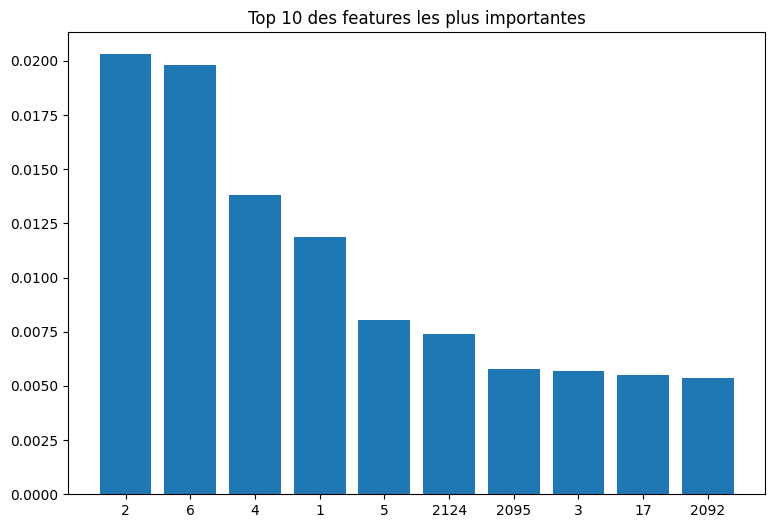

In [ ]:
# 7. Feature Importance
if hasattr(rf_model, 'feature_importances_'):
    print("\nTop 10 des features les plus importantes:")
    importances = rf_model.feature_importances_
    top_indices = np.argsort(importances)[-10:][::-1]

    for idx in top_indices:
        print(f"Feature {idx}: {importances[idx]:.4f}")

    plt.figure(figsize=(9, 6))
    plt.bar(range(10), importances[top_indices])
    plt.xticks(range(10), top_indices)
    plt.title("Top 10 des features les plus importantes")
    plt.show()

Sauvegarde du mod√®le Random Forest et du transformateur PCA

In [ ]:
# 8. Sauvegarde du mod√®le
model_path = '/content/drive/MyDrive/data/random_forest_model.joblib'
joblib.dump(rf_model, model_path)
print(f"\nMod√®le sauvegard√© √† : {model_path}")

# Si PCA a √©t√© appliqu√©, sauvegarder aussi le transformateur PCA
if 'pca' in locals():
    pca_path = '/content/drive/MyDrive/data/pca_transformer.joblib'
    joblib.dump(pca, pca_path)
    print(f"Transformateur PCA sauvegard√© √† : {pca_path}")


Mod√®le sauvegard√© √† : /content/drive/MyDrive/data/random_forest_model.joblib
Transformateur PCA sauvegard√© √† : /content/drive/MyDrive/data/pca_transformer.joblib


Code pour visualiser l'accuracy et la perte (Learning Curves)

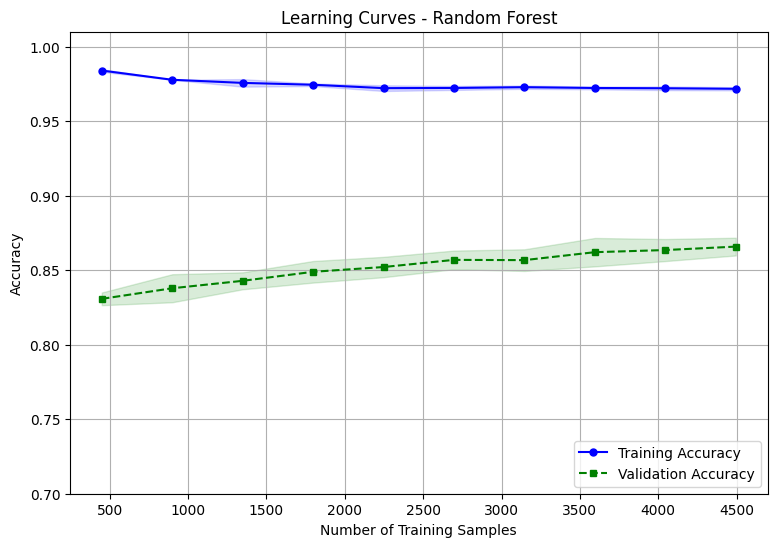

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Configuration des courbes d'apprentissage
train_sizes, train_scores, test_scores = learning_curve(
    estimator=rf_model,
    X=X_processed,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    n_jobs=-1,
    scoring='accuracy',
    random_state=42
)

# Calcul des moyennes et √©carts-types
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Trac√© des courbes
plt.figure(figsize=(9, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Learning Curves - Random Forest')
plt.ylim([0.7, 1.01])
plt.show()

Code pour afficher l'accuracy finale avec visualisation


                 Accuracy Finale                  
Jeu dentra√Ænement             : 0.9709
Jeu de test                   : 0.8639



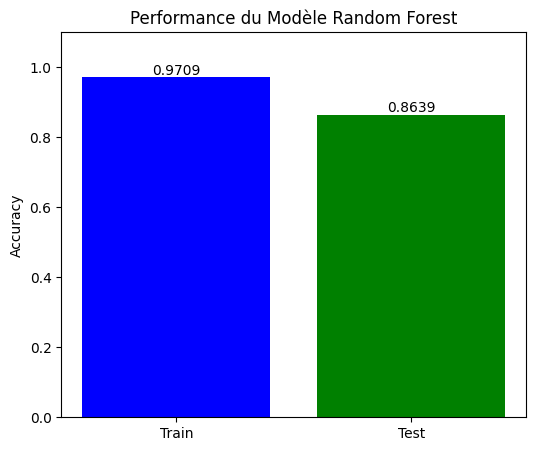

In [ ]:
from sklearn.metrics import accuracy_score

# Pr√©dictions
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Calcul des accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Affichage stylis√©
print("\n" + "="*50)
print(f"{'Accuracy Finale':^50}")
print("="*50)
print(f"{'Jeu dentra√Ænement':<30}: {train_accuracy:.4f}")
print(f"{'Jeu de test':<30}: {test_accuracy:.4f}")
print("="*50 + "\n")

# Visualisation graphique
plt.figure(figsize=(6, 5))
bars = plt.bar(['Train', 'Test'], [train_accuracy, test_accuracy], color=['blue', 'green'])

plt.ylim(0, 1.1)
plt.ylabel('Accuracy')
plt.title('Performance du Mod√®le Random Forest')

# Ajout des valeurs sur les barres
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom')

plt.show()

Recherche des meilleurs hyperparam√®tres pour le Random Forest avec GridSearchCV et √©valuation finale

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Dictionnaire d'hyperparam√®tres √† tester
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [10, 15],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced']
}

# Instanciation du mod√®le de base
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Configuration du GridSearch
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,                        # Validation crois√©e √† 3 plis
    scoring='accuracy',         # Ou 'f1', 'roc_auc', selon ton objectif
    verbose=2,
    n_jobs=-1                   # Utilisation maximale des c≈ìurs CPU
)

# Entra√Ænement
print("üîç Recherche des meilleurs hyperparam√®tres...")
grid_search.fit(X_train, y_train)

# R√©sultats
print("\nMeilleurs param√®tres trouv√©s :")
print(grid_search.best_params_)
print(f"Meilleure pr√©cision (CV) : {grid_search.best_score_:.4f}")

# Meilleur mod√®le entra√Æn√©
best_rf = grid_search.best_estimator_

# √âvaluation sur le test
test_accuracy = best_rf.score(X_test, y_test)
print(f"\nPr√©cision sur test avec meilleur mod√®le : {test_accuracy:.4f}")



üîç Recherche des meilleurs hyperparam√®tres...
Fitting 3 folds for each of 32 candidates, totalling 96 fits

Meilleurs param√®tres trouv√©s :
{'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 150}
Meilleure pr√©cision (CV) : 0.8601

Pr√©cision sur test avec meilleur mod√®le : 0.8648


√âvaluation du mod√®le Random Forest optimis√© : rapport de classification et matrice de confusion


üìÑ Rapport de classification :
              precision    recall  f1-score   support

           0       0.83      0.66      0.73       320
           1       0.87      0.95      0.91       804

    accuracy                           0.86      1124
   macro avg       0.85      0.80      0.82      1124
weighted avg       0.86      0.86      0.86      1124



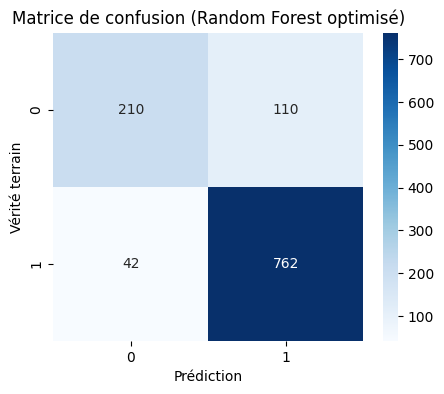

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Pr√©diction
y_pred = best_rf.predict(X_test)

# Rapport
print("\nüìÑ Rapport de classification :")
print(classification_report(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion (Random Forest optimis√©)")
plt.xlabel("Pr√©diction")
plt.ylabel("V√©rit√© terrain")
plt.show()


In [ ]:
import joblib

# Sauvegarde
joblib.dump(best_rf, '/content/drive/MyDrive/data/rf_best_model.joblib')
print("‚úÖ Mod√®le sauvegard√© avec succ√®s dans Google Drive.")


‚úÖ Mod√®le sauvegard√© avec succ√®s dans Google Drive.


√âvaluation finale du mod√®le Random Forest optimis√© : accuracy et visualisation graphique


        üéØ Accuracy Finale (GridSearch RF)         
Jeu dentra√Ænement             : 0.9726
Jeu de test                   : 0.8648



/tmp/ipython-input-25-829241242.py:35: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


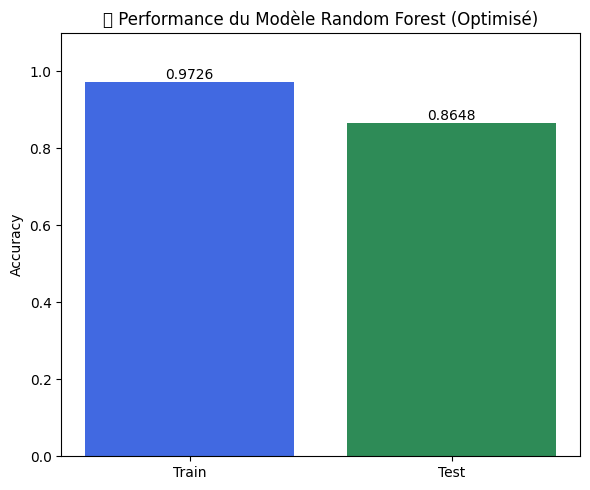

In [ ]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# --- 1. Pr√©dictions avec le mod√®le GridSearchCV ---
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

# --- 2. Accuracy ---
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# --- 3. Affichage format√© ---
print("\n" + "="*50)
print(f"{'üéØ Accuracy Finale (GridSearch RF)':^50}")
print("="*50)
print(f"{'Jeu dentra√Ænement':<30}: {train_accuracy:.4f}")
print(f"{'Jeu de test':<30}: {test_accuracy:.4f}")
print("="*50 + "\n")

# --- 4. Visualisation graphique ---
plt.figure(figsize=(6, 5))
bars = plt.bar(['Train', 'Test'], [train_accuracy, test_accuracy], color=['royalblue', 'seagreen'])

plt.ylim(0, 1.1)
plt.ylabel('Accuracy')
plt.title('üìä Performance du Mod√®le Random Forest (Optimis√©)')

# Valeurs sur les barres
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()


Courbes d'apprentissage du mod√®le Random Forest optimis√© (accuracy vs taille du jeu d'entra√Ænement)

/tmp/ipython-input-27-3345078991.py:41: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


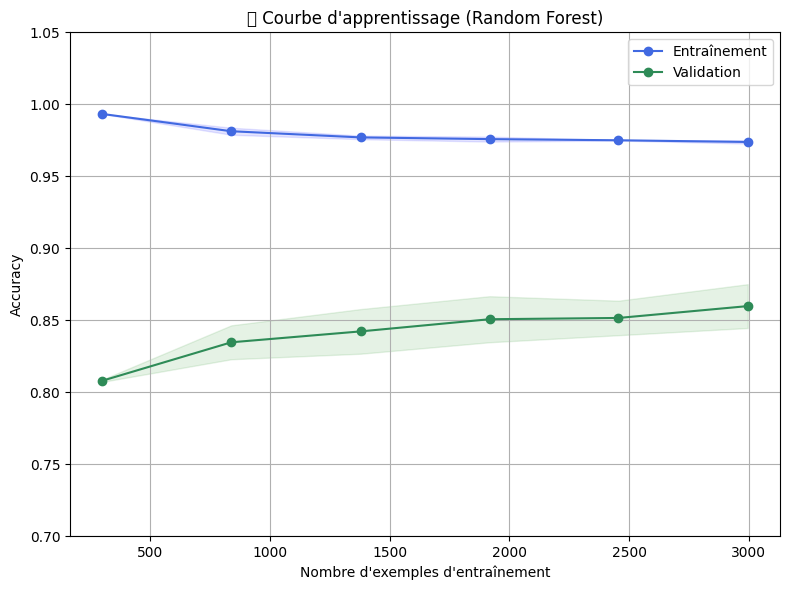

In [ ]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# --- Courbe d'apprentissage ---
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_rf,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 6),  # 10% √† 100% du jeu d'entra√Ænement
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

# Moyennes et √©cart-types
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std  = np.std(train_scores, axis=1)
test_scores_mean  = np.mean(test_scores, axis=1)
test_scores_std   = np.std(test_scores, axis=1)

# --- Plot ---
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='royalblue', label='Entra√Ænement')
plt.plot(train_sizes, test_scores_mean, 'o-', color='seagreen', label='Validation')

# Zones d'incertitude
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='green')

plt.title("üìà Courbe d'apprentissage (Random Forest)")
plt.xlabel("Nombre d'exemples d'entra√Ænement")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1.05)
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


Classification d'images avec SVM : Chargement, Pr√©traitement et Standardisation des Donn√©es

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
# 1. Chargement des donn√©es
X = np.load('/content/drive/MyDrive/data/preprocessed/X_train.npy')[:2000]
y = np.load('/content/drive/MyDrive/data/preprocessed/y_train.npy')[:2000]
# Flatten
X = X.reshape((X.shape[0], -1))

# 2. Train/test split + normalisation
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [2]:
# 3. PCA moins co√ªteux
from sklearn.decomposition import IncrementalPCA
pca = IncrementalPCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [3]:
# 6. D√©finition du mod√®le SVM + GridSearchCV
print("Optimisation du mod√®le SVM avec GridSearch...")
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.001, 0.01, 0.1],
    'kernel': ['rbf']
}

grid = GridSearchCV(SVC(probability=True), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
start_time = time.time()
grid.fit(X_train_pca, y_train)
end_time = time.time()

print(f"\nTemps d'entra√Ænement: {end_time - start_time:.2f} secondes")
print(f"Meilleurs hyperparam√®tres: {grid.best_params_}")

Optimisation du mod√®le SVM avec GridSearch...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Temps d'entra√Ænement: 48.03 secondes
Meilleurs hyperparam√®tres: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [4]:
# . √âvaluation du mod√®le
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_pca)
y_proba = best_model.predict_proba(X_test_pca)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.85      0.90       121
           1       0.94      0.98      0.96       279

    accuracy                           0.94       400
   macro avg       0.94      0.91      0.93       400
weighted avg       0.94      0.94      0.94       400




Matrice de confusion:


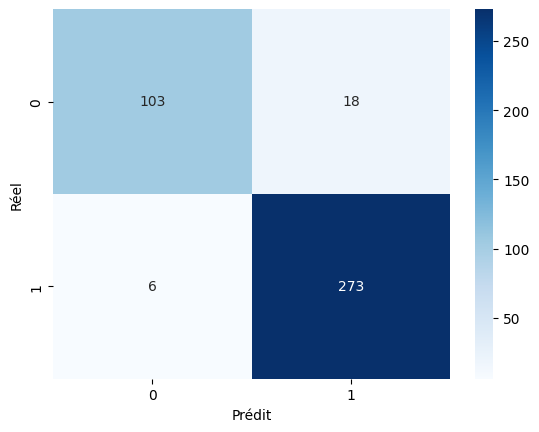

In [5]:
print("\nMatrice de confusion:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Pr√©dit")
plt.ylabel("R√©el")
plt.show()

In [6]:
auc_score = roc_auc_score(y_test, y_proba)
print(f"\nROC AUC Score: {auc_score:.4f}")


ROC AUC Score: 0.9794


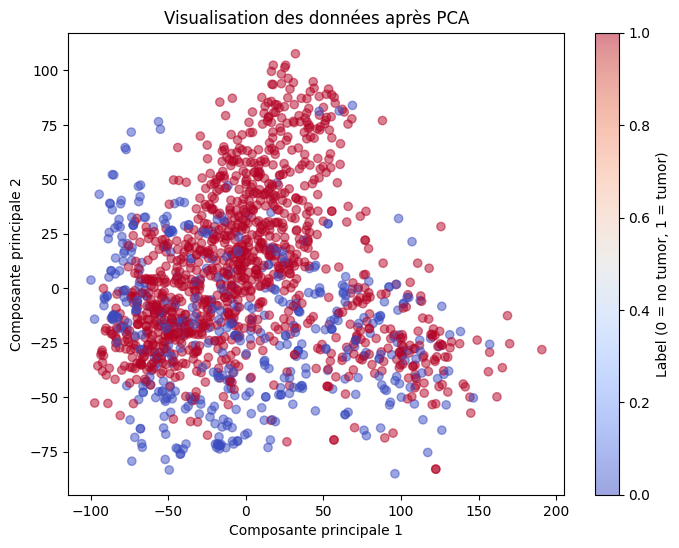

In [7]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='coolwarm', alpha=0.5)
plt.title("Visualisation des donn√©es apr√®s PCA")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.colorbar(scatter, label='Label (0 = no tumor, 1 = tumor)')
plt.show()

In [8]:
from sklearn.metrics import RocCurveDisplay, accuracy_score

#  1. Accuracy finale
accuracy = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_proba)
print(f"\nAccuracy : {accuracy:.4f}")
print(f"ROC AUC : {auc_score:.4f}")



Accuracy : 0.9400
ROC AUC : 0.9794


In [13]:
# Sauvegarde du mod√®le SVM, scaler et PCA
joblib.dump(best_model, '/content/drive/MyDrive/data/svm_brain_model.pkl')
joblib.dump(scaler, '/content/drive/MyDrive/data/scaler.pkl')
joblib.dump(pca, '/content/drive/MyDrive/data/pca.pkl')

print("\n‚úÖ Mod√®le, scaler et PCA sauvegard√©s avec succ√®s !")



‚úÖ Mod√®le, scaler et PCA sauvegard√©s avec succ√®s !


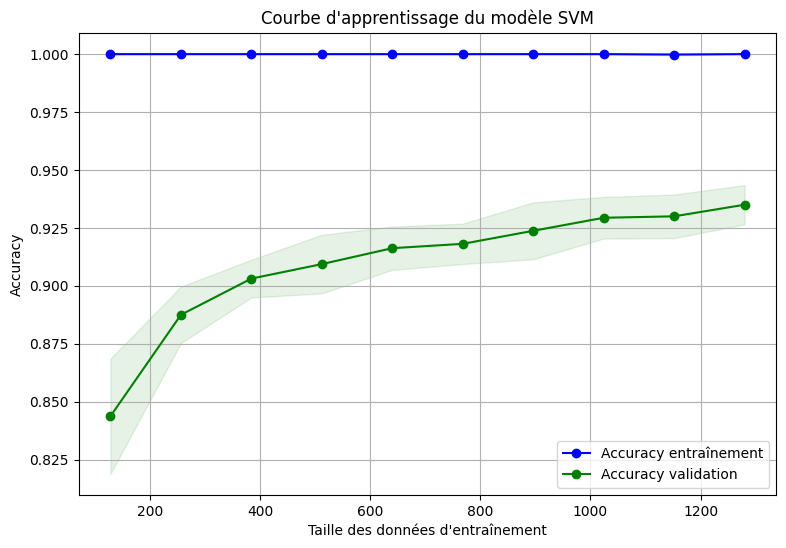

In [15]:
from sklearn.model_selection import learning_curve

# G√©n√©ration des courbes d'apprentissage
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train_pca, y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)

# Moyenne et √©cart type
train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

train_scores_std = np.std(train_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot
plt.figure(figsize=(9, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Accuracy entra√Ænement')
plt.plot(train_sizes, val_scores_mean, 'o-', color='green', label='Accuracy validation')

plt.fill_between(train_sizes,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std,
                 alpha=0.1, color="blue")
plt.fill_between(train_sizes,
                 val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std,
                 alpha=0.1, color="green")

plt.title("Courbe d'apprentissage du mod√®le SVM")
plt.xlabel("Taille des donn√©es d'entra√Ænement")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


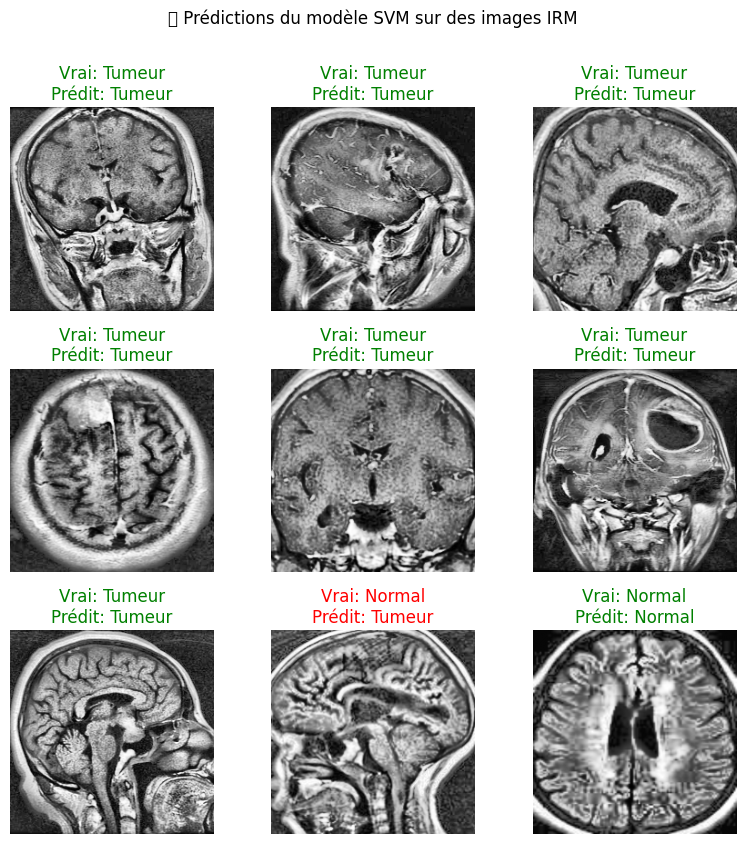

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Chargement des classes
class_names = ['Normal', 'Tumeur']

# 1. Recharger les images brutes (non flatten√©es)
X_raw = np.load('/content/drive/MyDrive/data/preprocessed/X_train.npy')[:2000]
y_raw = np.load('/content/drive/MyDrive/data/preprocessed/y_train.npy')[:2000]

# 2. Supprimer la dimension du canal si elle existe
if X_raw.ndim == 4 and X_raw.shape[-1] == 1:
    X_raw = X_raw.squeeze(-1)
elif X_raw.ndim == 4 and X_raw.shape[-1] == 3:
    X_raw = np.mean(X_raw, axis=-1)  # Convertir RGB en gris si besoin

# 3. Refait le m√™me split que pour l'entra√Ænement
X_raw_train, X_raw_test, y_raw_train, y_raw_test = train_test_split(
    X_raw, y_raw, stratify=y_raw, test_size=0.2, random_state=42
)

# 4. Pr√©dictions d√©j√† faites avec SVM (y_pred)
# S'assurer que y_pred a √©t√© d√©fini avec best_model.predict(X_test_pca)
# Exemple :
# y_pred = best_model.predict(X_test_pca)

# 5. Affichage de 9 exemples al√©atoires
plt.figure(figsize=(8, 8))
for i in range(9):
    idx = np.random.randint(len(X_raw_test))
    image = X_raw_test[idx]
    true_label = y_raw_test[idx]
    pred_label = y_pred[idx]  # pr√©diction d√©j√† faite plus t√¥t

    plt.subplot(3, 3, i + 1)
    plt.imshow(image, cmap='gray')
    color = 'green' if true_label == pred_label else 'red'
    plt.title(f"Vrai: {class_names[true_label]}\nPr√©dit: {class_names[pred_label]}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.suptitle("üéØ Pr√©dictions du mod√®le SVM sur des images IRM", y=1.05)
plt.show()


Classification IRM avec XGBoost

Installation

In [1]:
!pip install xgboost


Importation des biblioth√®ques

In [2]:
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


Chargement et Pr√©traitement des Donn√©es

In [3]:
# Charger les donn√©es (extrait de 2000 exemples)
X = np.load('/content/drive/MyDrive/data/preprocessed/X_train.npy')[:2000]
y = np.load('/content/drive/MyDrive/data/preprocessed/y_train.npy')[:2000]

# Aplatir les images (passage en 2D)
X = X.reshape((X.shape[0], -1))

# S√©parer train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


D√©finition et Entra√Ænement du Mod√®le XGBoost + GridSearch

In [4]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 1. D√©finir un mod√®le XGBoost l√©ger
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    verbosity=1
)

√âvaluation du Meilleur Mod√®le

In [5]:
# 2. Entra√Ænement
print("üîÅ Entra√Ænement du mod√®le XGBoost (l√©ger)...")
xgb_model.fit(X_train_scaled, y_train)

# 3. Pr√©dictions
y_pred = xgb_model.predict(X_test_scaled)
y_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

üîÅ Entra√Ænement du mod√®le XGBoost (l√©ger)...


In [6]:
# 4. √âvaluation
print("\nüìä Rapport de classification :")
print(classification_report(y_test, y_pred))
print(f"üéØ ROC AUC : {roc_auc_score(y_test, y_proba):.4f}")


üìä Rapport de classification :
              precision    recall  f1-score   support

           0       0.96      0.82      0.88       121
           1       0.93      0.99      0.95       279

    accuracy                           0.94       400
   macro avg       0.94      0.90      0.92       400
weighted avg       0.94      0.94      0.93       400

üéØ ROC AUC : 0.9848


Sauvegarde du Mod√®le et du Scaler

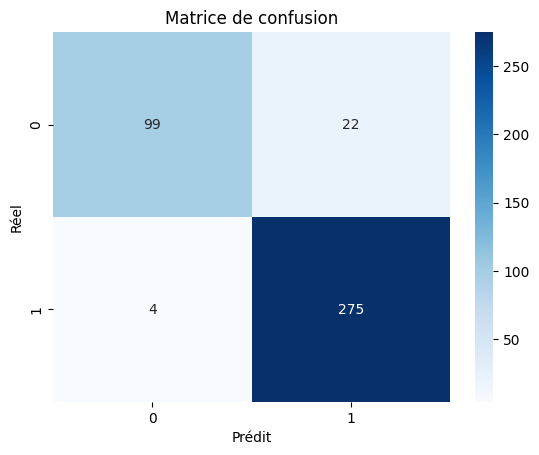

In [8]:
# 5. Matrice de confusion
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion")
plt.xlabel("Pr√©dit")
plt.ylabel("R√©el")
plt.show()


In [10]:
import joblib

# Chemin vers ton Drive (√† adapter si besoin)
model_path = '/content/drive/MyDrive/data/xgb_model_brain_tumor.joblib'

# Sauvegarder le mod√®le dans Google Drive
joblib.dump(xgb_model, model_path)
print(f"Mod√®le sauvegard√© dans : {model_path}")


Mod√®le sauvegard√© dans : /content/drive/MyDrive/data/xgb_model_brain_tumor.joblib


In [11]:
# --- Fonction pour tester une image IRM individuelle ---
def test_single_image(preprocessed_image, model, scaler):
    """
    Pr√©trait√©e, redimensionn√©e et normalis√©e image IRM (H, W)
    model : mod√®le XGBoost entra√Æn√©
    scaler : StandardScaler utilis√© sur les donn√©es
    """
    x = preprocessed_image.reshape(1, -1)             # Aplatir
    x_scaled = scaler.transform(x)                     # Normaliser
    pred_class = model.predict(x_scaled)[0]
    pred_prob = model.predict_proba(x_scaled)[0, 1]
    return pred_class, pred_prob

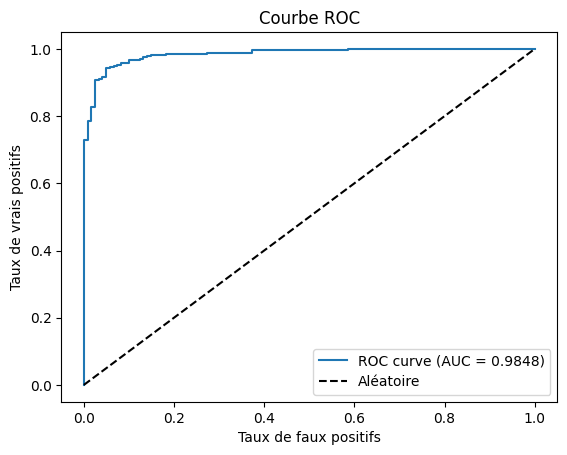

In [12]:
# --- Affichage de la courbe ROC / AUC ---
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_score:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Al√©atoire")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title("Courbe ROC")
plt.legend(loc="lower right")
plt.show()